# NLP Example bằng tiếng Việt using StackNetClassifier

## Credit: Code and Notebooks from https://github.com/ngxbac/aivivn_phanloaisacthaibinhluan

https://www.aivivn.com/

In [ ]:
import pandas as pd
import numpy as np

from scipy.sparse import hstack, csr_matrix, vstack

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn.ensemble import *
from sklearn.linear_model import *

from tqdm import *

import wordcloud
import matplotlib.pyplot as plt
import gc

import lightgbm as lgb
%matplotlib inline

In [4]:
# Load data
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [5]:
train_df.head()

,id,comment,label
0,train_000000,Dung dc sp tot cam on \nshop Đóng gói sản phẩm...,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng...,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đ...,1


In [6]:
test_df.head()

,id,comment
0,test_000000,Chưa dùng thử nên chưa biết
1,test_000001,Không đáng tiềnVì ngay đợt sale nên mới mua n...
2,test_000002,Cám ơn shop. Đóng gói sản phẩm rất đẹp và chắc...
3,test_000003,Vải đẹp.phom oki luôn.quá ưng
4,test_000004,Chuẩn hàng đóng gói đẹp


In [7]:
df = pd.concat([train_df, test_df], axis=0)
# del train_df, test_df
# gc.collect()

In [8]:
import emoji

def extract_emojis(str):
    return [c for c in str if c in emoji.UNICODE_EMOJI]

In [9]:
good_df = train_df[train_df['label'] == 0]
good_comment = good_df['comment'].values
good_emoji = []
for c in good_comment:
    good_emoji += extract_emojis(c)

good_emoji = np.unique(np.asarray(good_emoji))

In [10]:
bad_df = train_df[train_df['label'] == 1]
bad_comment = bad_df['comment'].values

bad_emoji = []
for c in bad_comment:
    bad_emoji += extract_emojis(c)

bad_emoji = np.unique(np.asarray(bad_emoji))

In [11]:
good_emoji

array(['↖', '↗', '☀', '☺', '♀', '♥', '✌', '✨', '❌', '❣', '❤', '⭐', '🆗',
       '🌝', '🌟', '🌧', '🌷', '🌸', '🌺', '🌼', '🍓', '🎈', '🎉', '🏻', '🏼', '🏿',
       '🐅', '🐾', '👉', '👌', '👍', '👏', '💋', '💌', '💐', '💓', '💕', '💖', '💗',
       '💙', '💚', '💛', '💜', '💞', '💟', '💥', '💪', '💮', '💯', '💰', '📑', '🖤',
       '😀', '😁', '😂', '😃', '😄', '😅', '😆', '😇', '😉', '😊', '😋', '😌', '😍',
       '😎', '😑', '😓', '😔', '😖', '😗', '😘', '😙', '😚', '😛', '😜', '😝', '😞',
       '😟', '😡', '😢', '😣', '😥', '😩', '😪', '😫', '😬', '😭', '😯', '😰', '😱',
       '😲', '😳', '😻', '😿', '🙁', '🙂', '🙃', '🙄', '🙆', '🙌', '🤑', '🤔', '🤗',
       '🤙', '🤝', '🤣', '🤤', '🤨', '🤪', '🤭'], dtype='<U1')

In [12]:
# Just remove "sad, bad" emoji :D
good_emoji_fix = [
    '↖', '↗', '☀', '☺', '♀', '♥', '✌', '✨', '❣', '❤', '⭐', '🆗',
       '🌝', '🌟', '🌧', '🌷', '🌸', '🌺', '🌼', '🍓', '🎈', '🎉', '🐅', '🐾', '👉',
       '👌', '👍', '👏', '💋', '💌', '💐', '💓', '💕', '💖', '💗', '💙', '💚', '💛',
       '💜', '💞', '💟', '💥', '💪', '💮', '💯', '💰', '📑', '🖤', '😀', '😁', '😂',
       '😃', '😄', '😅', '😆', '😇', '😉', '😊', '😋', '😌', '😍', '😎', '😑', '😓', '😔', 
    '😖', '😗', '😘', '😙', '😚', '😛', '😜', '😝', '😞', '😟', '😡', '😯', '😰', '😱', '😲', '😳', '😻', '🙂', '🙃', '🙄', '🙆', '🙌', '🤑', '🤔', '🤗',
]

In [13]:
bad_emoji

array(['☹', '✋', '❌', '❓', '❤', '⭐', '🎃', '🏻', '🏼', '🏿', '👌', '👍', '👎',
       '👶', '💀', '💋', '😁', '😂', '😈', '😊', '😌', '😏', '😐', '😑', '😒', '😓',
       '😔', '😖', '😚', '😞', '😟', '😠', '😡', '😢', '😣', '😤', '😥', '😧', '😩',
       '😪', '😫', '😬', '😭', '😳', '😵', '😶', '🙁', '🙂', '🙄', '🤔', '🤚', '🤤'],
      dtype='<U1')

In [14]:
# Just remove "good" emoji :D
bad_emoji_fix = [
    '☹', '✋', '❌', '❓', '👎', '👶', '💀',
       '😐', '😑', '😒', '😓', '😔',
       '😞', '😟', '😠', '😡', '😢', '😣', '😤', '😥', '😧', '😩', '😪', '😫', '😬',
       '😭', '😳', '😵', '😶', '🙁', '🙄', '🤔',
]

In [15]:
def count_good_bad_emoji(row):
    comment = row['comment']
    n_good_emoji = 0
    n_bad_emoji = 0
    for c in comment:
        if c in good_emoji_fix:
            n_good_emoji += 1
        if c in bad_emoji_fix:
            n_bad_emoji += 1
    
    row['n_good_emoji'] = n_good_emoji
    row['n_bad_emoji'] = n_bad_emoji
    
    return row

In [16]:
# Some features
df['comment'] = df['comment'].astype(str).fillna(' ')
df['comment'] = df['comment'].str.lower()
df['num_words'] = df['comment'].apply(lambda s: len(s.split()))
df['num_unique_words'] = df['comment'].apply(lambda s: len(set(w for w in s.split())))
df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] * 100
df = df.apply(count_good_bad_emoji, axis=1)

In [17]:
df['good_bad_emoji_ratio'] = df['n_good_emoji'] / df['n_bad_emoji']
df['good_bad_emoji_ratio'] = df['good_bad_emoji_ratio'].replace(np.nan, 0)
df['good_bad_emoji_ratio'] = df['good_bad_emoji_ratio'].replace(np.inf, 99)
df['good_bad_emoji_diff'] = df['n_good_emoji'] - df['n_bad_emoji']
df['good_bad_emoji_sum'] = df['n_good_emoji'] + df['n_bad_emoji']

In [18]:
train_df = df[~df['label'].isnull()]
test_df = df[df['label'].isnull()]

train_comments = train_df['comment'].fillna("none").values
test_comments = test_df['comment'].fillna("none").values

y_train = train_df['label'].values

In [19]:
train_df.head()

,id,comment,label,num_words,num_unique_words,words_vs_unique,n_good_emoji,n_bad_emoji,good_bad_emoji_ratio,good_bad_emoji_diff,good_bad_emoji_sum
0,train_000000,dung dc sp tot cam on \nshop đóng gói sản phẩm...,0.0,22,20,90.909091,0,0,0.0,0,0
1,train_000001,chất lượng sản phẩm tuyệt vời . son mịn nhưng...,0.0,18,18,100.000000,0,0,0.0,0,0
2,train_000002,chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0.0,18,14,77.777778,0,0,0.0,0,0
3,train_000003,:(( mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1.0,114,91,79.824561,0,0,0.0,0,0
4,train_000004,lần trước mình mua áo gió màu hồng rất ok mà đ...,1.0,26,24,92.307692,0,0,0.0,0,0


Tạo feature TFIDF đơn giản

In [20]:
tfidf = TfidfVectorizer(
    min_df = 5, 
    max_df = 0.8, 
    max_features=10000,
    sublinear_tf=True
)

In [21]:
X_train_tfidf = tfidf.fit_transform(train_comments)
X_test_tfidf = tfidf.transform(test_comments)

In [22]:
EXCLUED_COLS = ['id', 'comment', 'label']
static_cols = [c for c in train_df.columns if not c in EXCLUED_COLS]
X_train_static = train_df[static_cols].values
X_test_static = test_df[static_cols].values

In [23]:
X_train = hstack([X_train_tfidf, csr_matrix(X_train_static)]).tocsr()
X_test = hstack([X_test_tfidf, csr_matrix(X_test_static)]).tocsr()
# X_train = X_train_tfidf
# X_test = X_test_tfidf

In [24]:
X_train.shape, X_test.shape, y_train.shape

((16087, 2687), (10981, 2687), (16087,))

# Stacking method

In [25]:
models=[ 
    ######## First level ########
    [
        RandomForestClassifier (n_estimators=100, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
        ExtraTreesClassifier (n_estimators=100, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
        GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, max_features=0.5, random_state=1),
        LogisticRegression(random_state=1)
    ],
    ######## Second level ########
    [
        RandomForestClassifier (n_estimators=200, criterion="entropy", max_depth=5, max_features=0.5, random_state=1)
    ]
]

In [28]:
from pystacknet.pystacknet import StackNetClassifier

model = StackNetClassifier(
    models, metric="f1", 
    folds=5,
    restacking=False, 
    use_retraining=True, 
    use_proba=True, 
    random_state=12345, n_jobs=1, verbose=1
)

model.fit(X_train, y_train)
preds=model.predict_proba(X_test)

====================== Start of Level 0 ======================
Input Dimensionality 2687 at Level 0 
4 models included in Level 0 


/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Level 0, fold 1/5 , model 0 , f1===0.789457 
Level 0, fold 1/5 , model 1 , f1===0.813472 
Level 0, fold 1/5 , model 2 , f1===0.857641 
Level 0, fold 1/5 , model 3 , f1===0.865303 
=========== end of fold 1 in level 0 ===========


/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Level 0, fold 2/5 , model 0 , f1===0.812040 
Level 0, fold 2/5 , model 1 , f1===0.824688 
Level 0, fold 2/5 , model 2 , f1===0.865074 
Level 0, fold 2/5 , model 3 , f1===0.872805 
=========== end of fold 2 in level 0 ===========


/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Level 0, fold 3/5 , model 0 , f1===0.804277 
Level 0, fold 3/5 , model 1 , f1===0.821736 
Level 0, fold 3/5 , model 2 , f1===0.876429 
Level 0, fold 3/5 , model 3 , f1===0.876494 
=========== end of fold 3 in level 0 ===========


/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Level 0, fold 4/5 , model 0 , f1===0.800000 
Level 0, fold 4/5 , model 1 , f1===0.825202 
Level 0, fold 4/5 , model 2 , f1===0.873005 
Level 0, fold 4/5 , model 3 , f1===0.863442 
=========== end of fold 4 in level 0 ===========


/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Level 0, fold 5/5 , model 0 , f1===0.802153 
Level 0, fold 5/5 , model 1 , f1===0.813953 
Level 0, fold 5/5 , model 2 , f1===0.861043 
Level 0, fold 5/5 , model 3 , f1===0.873807 
=========== end of fold 5 in level 0 ===========
Level 0, model 0 , f1===0.801585 
Level 0, model 1 , f1===0.819810 
Level 0, model 2 , f1===0.866638 
Level 0, model 3 , f1===0.870370 


/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Output dimensionality of level 0 is 4 
====================== End of Level 0 ======================
 level 0 lasted 102.148064 seconds 
====================== Start of Level 1 ======================
Input Dimensionality 4 at Level 1 
1 models included in Level 1 
Level 1, fold 1/5 , model 0 , f1===0.872932 
=========== end of fold 1 in level 1 ===========
Level 1, fold 2/5 , model 0 , f1===0.874336 
=========== end of fold 2 in level 1 ===========
Level 1, fold 3/5 , model 0 , f1===0.883098 
=========== end of fold 3 in level 1 ===========
Level 1, fold 4/5 , model 0 , f1===0.875176 
=========== end of fold 4 in level 1 ===========
Level 1, fold 5/5 , model 0 , f1===0.878459 
=========== end of fold 5 in level 1 ===========
Level 1, model 0 , f1===0.876800 
Output dimensionality of level 1 is 1 
====================== End of Level 1 ======================
 level 1 lasted 18.519124 seconds 
====================== End of fit ======================
 fit() lasted 120.668525 seconds 
======

In [29]:
pred_cls = np.argmax(preds, axis=1)

In [32]:
# submission = pd.read_csv("./data/sample_submission.csv")
# submission['label'] = pred_cls

In [ ]:
# submission.head()

In [ ]:
# submission.to_csv("stack_demo.csv", index=False)

# Ensemble method

In [33]:
from sklearn.model_selection import cross_val_predict
models = [
    RandomForestClassifier (n_estimators=100, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
    ExtraTreesClassifier (n_estimators=100, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, max_features=0.5, random_state=1),
    LogisticRegression(random_state=1)
]

In [34]:
def cross_val_and_predict(clf, X, y, X_test, nfolds):
    kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
    
    oof_preds = np.zeros((X.shape[0], 2))
    sub_preds = np.zeros((X_test.shape[0], 2))
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        
        clf.fit(X_train, y_train)
        
        oof_preds[valid_idx] = clf.predict_proba(X_valid)
        sub_preds += clf.predict_proba(X_test) / kf.n_splits
        
    return oof_preds, sub_preds

In [35]:
sub_preds = []

for clf in models:
    oof_pred, sub_pred = cross_val_and_predict(clf, X_train, y_train, X_test, nfolds=5)
    oof_pred_cls = oof_pred.argmax(axis=1)
    oof_f1 = f1_score(y_pred=oof_pred_cls, y_true=y_train)
    
    print(clf.__class__)
    print(f"F1 CV: {oof_f1}")
    
    sub_preds.append(sub_pred)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
F1 CV: 0.8036813709933355
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
F1 CV: 0.8206730456291089
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
F1 CV: 0.864902800196505


/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/home/gao/anaconda3/lib/python3.7/si

<class 'sklearn.linear_model._logistic.LogisticRegression'>
F1 CV: 0.8695652173913043


/home/gao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [36]:
sub_preds = np.asarray(sub_preds)
sub_preds = sub_preds.mean(axis=0)
sub_pred_cls = sub_preds.argmax(axis=1)

In [38]:
# submission_ensemble = submission.copy()
# submission_ensemble['label'] = sub_pred_cls
# submission_ensemble.to_csv("ensemble.csv", index=False)

In [41]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import wordcloud
import matplotlib.pyplot as plt
import gc

import lightgbm as lgb
%matplotlib inline

# Load data
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

train_df.head()

test_df.head()

train_comments = train_df['comment'].fillna("none").values
test_comments = test_df['comment'].fillna("none").values

y_train = train_df['label'].values

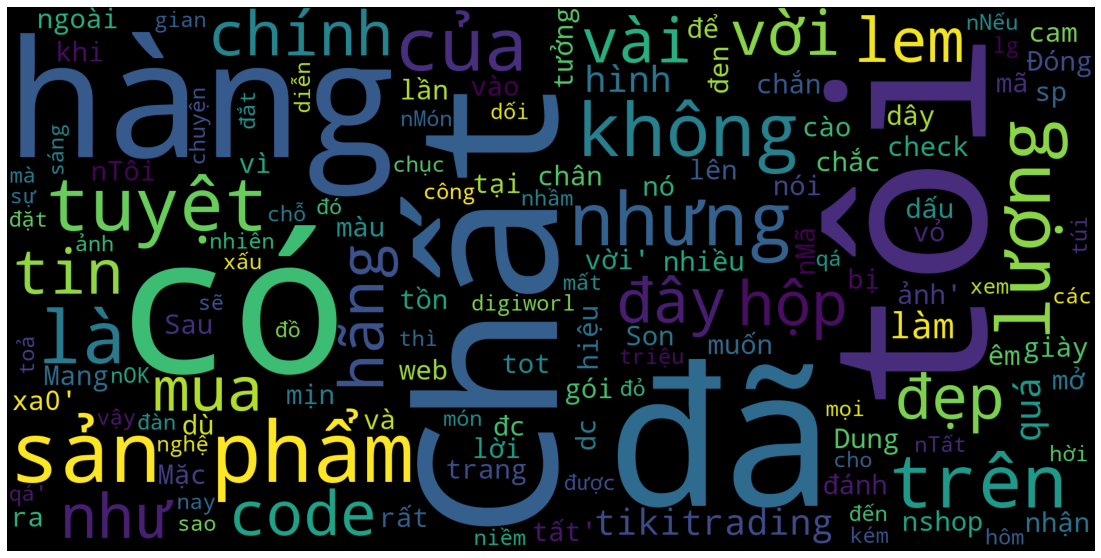

In [42]:
# Wordcloud of training set
cloud = np.array(train_comments).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(
    max_words=200,background_color ="black",
    width=2000,height=1000,mode="RGB"
).generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

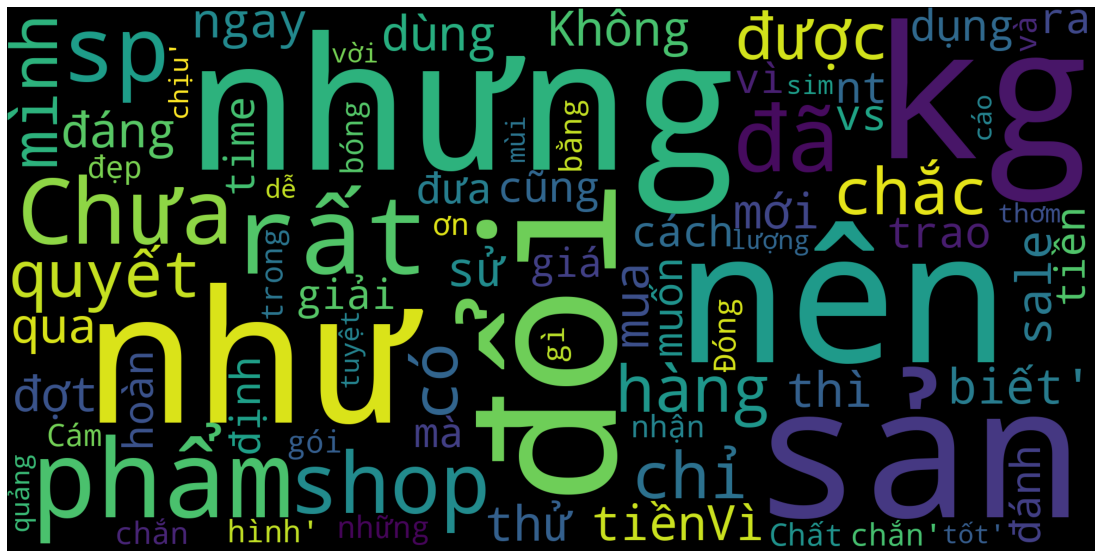

In [40]:

# Wordcloud of test set
cloud = np.array(test_comments).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(
    max_words=100,background_color ="black",
    width=2000,height=1000,mode="RGB"
).generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)



In [ ]:
tfidf = TfidfVectorizer(
    min_df=5, 
    max_df= 0.8, 
    max_features=10000,
    sublinear_tf=True
)

X_train = tfidf.fit_transform(train_comments)
X_test = tfidf.transform(test_comments)

X_train.shape, X_test.shape, y_train.shape

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

print("Starting LightGBM. Train shape: {}, test shape: {}".format(X_train.shape, X_test.shape))

# Cross validation model
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

# Create arrays and dataframes to store results
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

# k-fold
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    print("Fold %s" % (n_fold))
    train_x, train_y = X_train[train_idx], y_train[train_idx]
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                           label=valid_y,
                           free_raw_data=False)

    params = {
        'objective' :'binary',
        'learning_rate' : 0.01,
        'num_leaves' : 76,
        'feature_fraction': 0.64, 
        'bagging_fraction': 0.8, 
        'bagging_freq':1,
        'boosting_type' : 'gbdt',
    }

    reg = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'valid'],
        num_boost_round=10000,
        verbose_eval=100,
        early_stopping_rounds=100,
        feval=lgb_f1_score
    )

    oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
    sub_preds += reg.predict(X_test, num_iteration=reg.best_iteration) / folds.n_splits

    del reg, train_x, train_y, valid_x, valid_y
    gc.collect()

threshold = 0.5
preds = (sub_preds > threshold).astype(np.uint8)

Starting LightGBM. Train shape: (16087, 2679), test shape: (10981, 2679)
Fold 0
[LightGBM] [Info] Number of positive: 5445, number of negative: 7424
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52352
[LightGBM] [Info] Number of data points in the train set: 12869, number of used features: 1137
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423110 -> initscore=-0.310020
[LightGBM] [Info] Start training from score -0.310020
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.393295	train's f1: 0.874977	valid's binary_logloss: 0.410023	valid's f1: 0.851221
[200]	train's binary_logloss: 0.290724	train's f1: 0.893252	valid's binary_logloss: 0.323003	valid's f1: 0.865039
[300]	train's binary_logloss: 0.238792	train's f1: 0.90528	valid's binary_logloss: 0.287577	valid's f1: 0.872143
[400]	train's binar